<a href="https://colab.research.google.com/github/DomingosLemos/Deploy-cnn-test/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet50

# Importar as livrarias necessárias

In [ ]:
!pip install split-folders
import splitfolders
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import h5py
#import gc
import tensorflow as tf
#from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
#from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D


#models
from keras.applications.resnet50 import ResNet50

### Montar a google drive onde temos um zip com totalidade das imagens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Descompactar imagens para pastas

In [ ]:
!7z x /content/drive/MyDrive/EDSA/images.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/EDSA/                                      1 file, 4942431249 bytes (4714 MiB)

Extracting archive: /content/drive/MyDrive/EDSA/images.7z
--
Path = /content/drive/MyDrive/EDSA/images.7z
Type = 7z
Physical Size = 4942431249
Headers Size = 1206945
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 102          0% 185 - images/apple_pie/1295996.jpg                                         0% 274 - images/apple_pie/1626685.jpg                                         0% 360 - ima

### Fazer o Split das imagens com splitfolder

> Bloco com avanço


Colocar:
* content/output/train com 70% (700 imagens em cada pasta)
* content/output/val com 20% (200 imagens em cada pasta)
* content/output/test com 10% (100 imagens em cada pasta)



In [ ]:
splitfolders.ratio('/content/images', output="output", seed=1337, ratio=(.7, .2, .1)) 

Copying files: 101000 files [01:51, 903.83 files/s] 


## ResNet50

Como temos um dataset pequeno para cada categoria (700 imagens) vamos usar o "Image Augmentation" para aumentar um pouco o tamanho do nosso dataset

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Obter os dados

In [ ]:
#n_classes = 101
img_width, img_height = 224, 224 # Standard shape for pre-trained model
train_data_dir = '/content/output/train'
validation_data_dir = '/content/output/val'
nb_train_samples = 70700
nb_validation_samples = 20200
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 70700 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [ ]:
#Build the Model
#We will use this model just as a layer in a Sequential model, and just add a single Fully Connected Layer on top of it
base_model = Sequential()
base_model.add(ResNet50(input_shape = (224, 224,3), # Standard shape for pre-trained model
                        include_top=False,          # Leave out the last fully connected layer
                        weights='imagenet', 
                        pooling='max'))
base_model.add(Dense(101, activation='softmax'))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
gc.collect()

In [ ]:
#Since we don’t have to train all the layers, we make them non_trainable
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])


early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8)
checkpoint_callback = ModelCheckpoint('ResNet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Fit model
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = nb_train_samples // batch_size, validation_steps=nb_validation_samples // batch_size, 
                                epochs = 30, callbacks=[early_stopping_callback, checkpoint_callback] )

model.save('model_trained_resnet.hdf5')

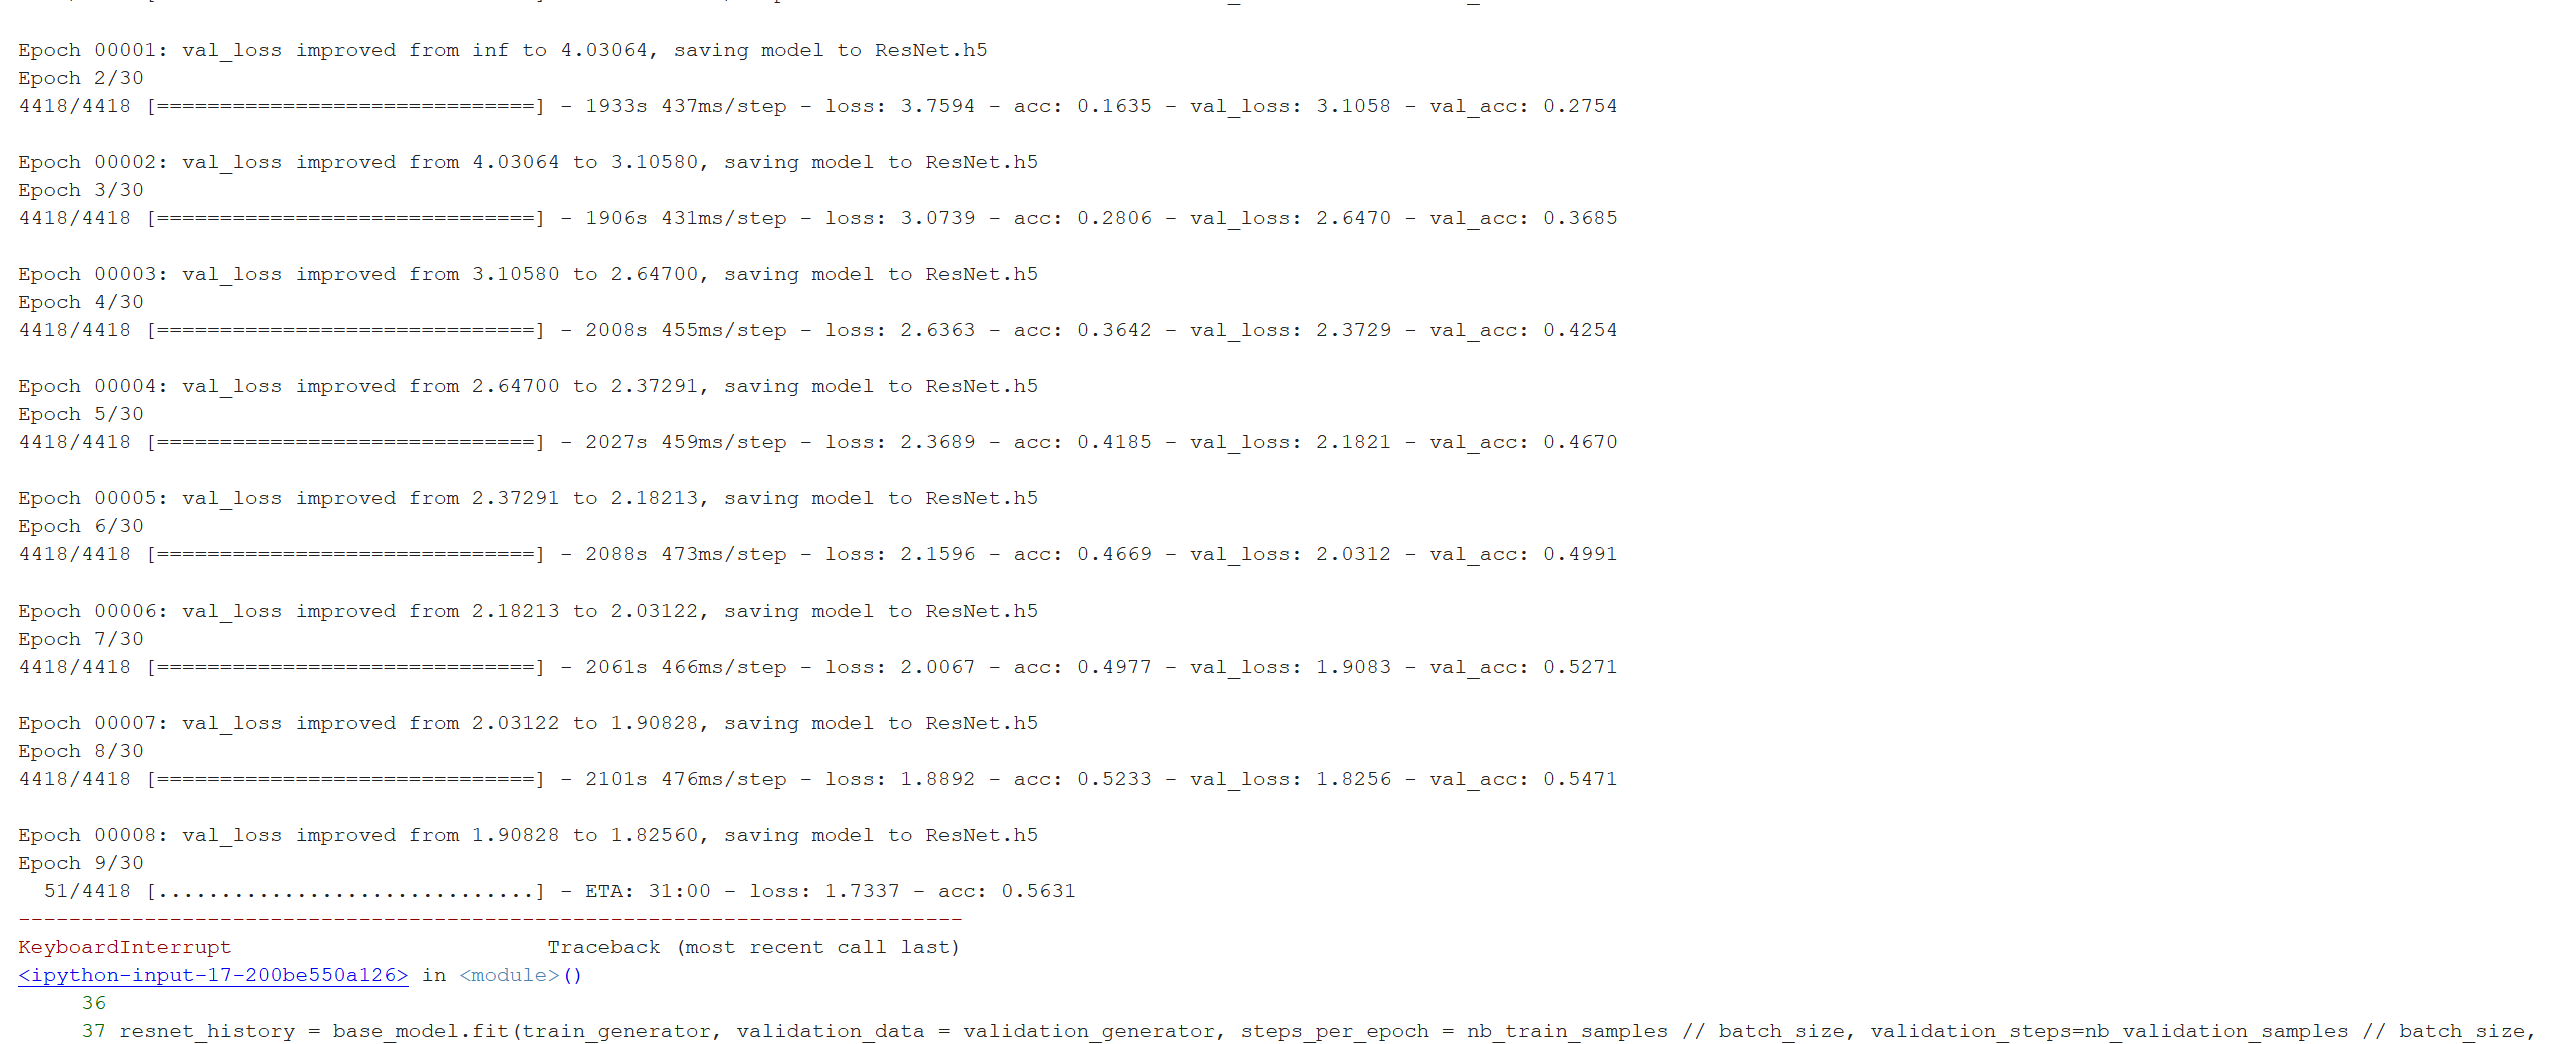

In [ ]:
#Due to a google colab error, the ouput of the mode was not saved when it was interrupted. However, this was not the first occurence, therefore we took printscreens of each epoch. 
#The model was interrupted because it would not surpass our Inception model and we had to manage our time

from IPython.display import Image
Image('/content/drive/MyDrive/EDSA/ResNet.png')